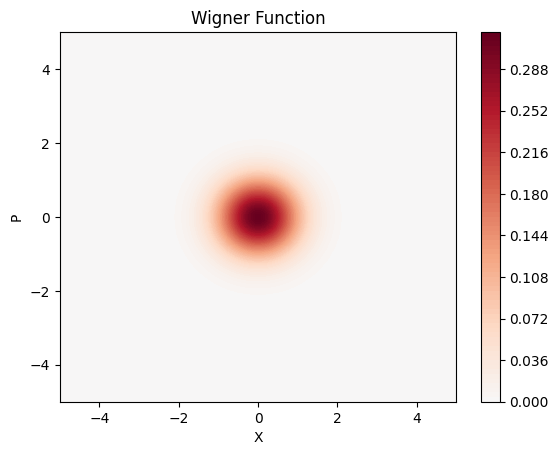

Time: 0.0
Number: 1.1102230246251565e-16
Parity: 0.9999999999999999
Time: 0.01
Number: 0.0009002700324020063
Parity: 1.0000000000000002
Time: 0.02
Number: 0.0033429352667000423
Parity: 0.9998199622022692
Time: 0.03
Number: 0.009053277114365432
Parity: 0.999187933882879
Time: 0.04
Number: 0.017198435862924022
Parity: 0.997545253214362
Time: 0.05
Number: 0.027244683384753055
Parity: 0.9946242626547689
Time: 0.06
Number: 0.03881158495732362
Parity: 0.9903384842172954
Time: 0.07
Number: 0.05158484352268222
Parity: 0.9847193793713452
Time: 0.08
Number: 0.06530375426223778
Parity: 0.9778784740114448
Time: 0.09
Number: 0.07975236528003737
Parity: 0.9699761434473572
Time: 0.1
Number: 0.09475223074457217
Parity: 0.9611966734564659
Time: 0.11
Number: 0.11015632398427444
Parity: 0.9517294844535756
Time: 0.12
Number: 0.12584389252631456
Parity: 0.9417560405280028
Time: 0.13
Number: 0.14171610275626678
Parity: 0.9314416203210701
Time: 0.14
Number: 0.1576923557814187
Parity: 0.9209309456314781
Time:

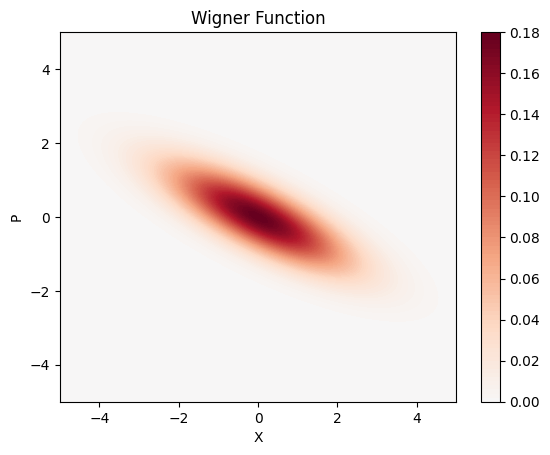

[[ 1.          0.          0.          0.          0.          0.53247898
  -0.64808336 -0.50390068]]


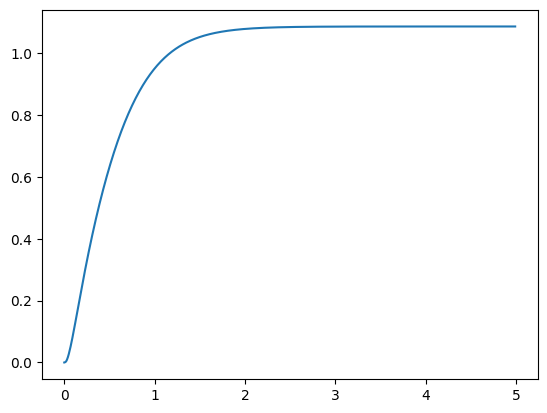

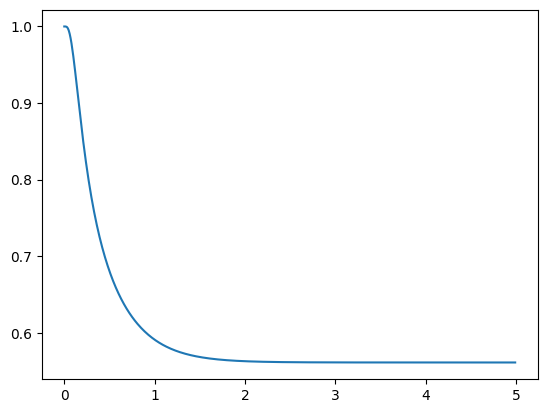

In [99]:
import jax.numpy as jnp
import jax.numpy.linalg as jla
import jax
import jax.scipy.linalg as jsl
import matplotlib.pyplot as plt
import matplotlib
from functools import partial
from typing import Union, Tuple, Iterator
import fractions
import itertools
import functools
import math
import numpy as np

import jax
import jax.numpy as jnp
from jax.experimental import jet

jax.config.update("jax_enable_x64", True)

Rational = Union[int, fractions.Fraction]


@functools.lru_cache(maxsize=None)
def binomial_coeff(n: Rational, k: int) -> Rational:
    """Compute the binomial coefficient n choose k, extended to rational n."""
    if k < 0:
        raise ValueError("k must be a non-negative integer")
    n = fractions.Fraction(n)
    result = 1
    for i in range(k):
        result *= (n - i) / (i + 1)
    return result


MultiIndex = Tuple[int, ...]


def multi_index_lte(i: MultiIndex) -> Iterator[MultiIndex]:
    """Generate all multi-indices 0 < j <= i."""
    return itertools.islice(
        itertools.product(*(range(0, k + 1) for k in i)),
        1,
        None,
    )


@functools.lru_cache(maxsize=None)
def multi_index_binomial_coeff(i: Tuple[Rational, ...],
                               j: MultiIndex) -> Rational:
    """Compute the multi-index binomial coefficient i choose j."""
    result = 1
    for i_k, j_k in zip(i, j):
        result *= binomial_coeff(i_k, j_k)
    return result


def coeffs(i: MultiIndex) -> Iterator[Tuple[MultiIndex, Rational]]:
    for j in multi_index_lte(i):
        c = multi_index_binomial_coeff(i, j) * (-1)**(sum(i) - sum(j))
        if c != 0:
            yield j, c


@functools.lru_cache(maxsize=None)
def precompute_kc(orders: MultiIndex) -> Tuple[np.ndarray, np.ndarray]:
    ks, cs = [], []
    for k, c in coeffs(orders):
        k = np.array(list(map(float, k)))
        c = float(c)
        # (Optional) Normalize the perturbation directions
        # n = np.linalg.norm(k)
        # k /= n
        # c *= n**sum(orders)
        ks.append(list(k))
        cs.append(c)
    ks = np.array(ks)
    cs = np.array(cs)
    return ks, cs


def mixed_partial(f, orders: MultiIndex):
    """Implements Eq 13 of the paper `Evaluating Higher Derivative Tensors by Forward Propagation of Univariate Taylor Series`"""
    d = sum(orders)
    ks, cs = precompute_kc(orders)
    dfact = math.factorial(d)

    def partial_der(x0):

        @jax.vmap
        def jetter(j):
            hs = (j, ) + (jnp.zeros_like(x0), ) * (d - 1)
            _, (*_, res) = jet.jet(
                f,
                (x0, ),
                (hs, ),
            )
            return res

        return jnp.sum(jetter(ks) * cs) / dfact

    return partial_der


G = 3 + 3j
delta = 1
U = 1
gamma = 10
#param_a, param_b: list of dict?

def calculate_covariance(covariance_params):
    x, y, phi = covariance_params
    # Rotation matrix
    R = jnp.array([
        [jnp.cos(phi), -jnp.sin(phi)],
        [jnp.sin(phi), jnp.cos(phi)]
    ])
    # Scaling matrix
    S = jnp.array([
        [jnp.exp(x), 0],
        [0, jnp.exp(y)]
    ])
    # Covariance matrix as R * S * R^T
    Sigma = R@S@S@R.T
    return Sigma

def unwrap_params(params):
    normalization = params[0]
    mean = params[1:5]
    covariance_params = params[5:8]
    return normalization, mean, covariance_params

def generating_function(params_a, params_b, Js):
    normalization_a, mean_a, covariance_params_a = unwrap_params(params_a)
    normalization_b, mean_b, covariance_params_b = unwrap_params(params_b)
    alpha_a, beta_a = mean_a[::2], mean_a[1::2]
    alpha_b, beta_b =  mean_b[::2], mean_b[1::2]
    J, J_tilde = Js[:Js.size//2], Js[Js.size//2:]
    
    # M is the number of modes used in the prefactor normalization
    M_modes = 1
    covariance_a = calculate_covariance(covariance_params_a)
    covariance_b = calculate_covariance(covariance_params_b)
    
    covariance_sum = covariance_a + covariance_b
    covariance_sum_inv = jla.inv(covariance_sum)
    
    v1 = alpha_b - alpha_a - jnp.dot(covariance_a, J) - J_tilde
    inv_sigma_sum_v1 = jnp.dot(covariance_sum_inv, v1)
    
    # Helper vectors for Beta terms (Eq A15)
    diff_beta = beta_b - beta_a
    sum_beta = beta_b + beta_a
    inv_sigma_sum_diff_beta = jnp.dot(covariance_sum_inv, diff_beta)
    inv_sigma_sum_sum_beta = jnp.dot(covariance_sum_inv, sum_beta)

    Z1 = jnp.exp(-0.5 * jnp.dot(v1, inv_sigma_sum_v1))
    
    M_minus = jnp.exp(0.5 * jnp.dot(diff_beta, inv_sigma_sum_diff_beta))
    
    M_plus = jnp.exp(0.5 * jnp.dot(sum_beta, inv_sigma_sum_sum_beta))
    
    J_dot_beta = jnp.dot(J, beta_a)
    
    mix_term_minus = jnp.dot(diff_beta, inv_sigma_sum_v1)
    mix_term_plus = jnp.dot(sum_beta, inv_sigma_sum_v1)
    
    C_minus = jnp.cos(J_dot_beta - mix_term_minus)
    C_plus = jnp.cos(J_dot_beta + mix_term_plus)
    num_exponent = 0.5 * jnp.dot(J, jnp.dot(covariance_a, J)) + jnp.dot(J, alpha_a)
    
    # Denominator: sqrt((2*pi)^M * det(Sigma + Sigma'))
    # Calculated in log domain for stability: 0.5 * (M * log(2pi) + logdet)
    sign, logdet = jnp.linalg.slogdet(covariance_sum)
    log_denominator = 0.5 * (2*M_modes * jnp.log(2 * jnp.pi) + logdet)
    
    # Combine prefactor terms: exp(num_exponent - log_denominator)
    prefactor = 0.5 * jnp.exp(num_exponent - log_denominator)
    
    # 8. Final Result (Eq A13)
    return normalization_a*normalization_b*prefactor * Z1 * (M_minus * C_minus + M_plus * C_plus)


@jax.jit
def geometric_tensor(params):
    def total_gen_func(params_a, params_b):
        return jnp.sum(jax.vmap(lambda param_a: jax.vmap(lambda param_b: generating_function(param_a, param_b, jnp.zeros((4))))(params_a))(params_b))
    return jax.jacfwd(jax.grad(total_gen_func, argnums=(1)), argnums=(0))(params, params).reshape(params.size, params.size)

def g(param_a, param_b, orders):
    if sum(orders) == 0:
        return generating_function(param_a, param_b, jnp.zeros((4)))
    g_f = partial(generating_function, param_a, param_b)
    return mixed_partial(g_f, orders)(jnp.zeros((4)))

def g_term(param_a, param_b):
    real_term = jnp.real(G)*(g(param_a, param_b,(0,1,1,0))+g(param_a, param_b,(1,0,0,1)))
    imag_term = jnp.imag(G)*(g(param_a, param_b,(1,0,1,0))-g(param_a, param_b,(0,1,0,1)))
    return real_term - imag_term

def delta_term(param_a, param_b):
    return delta*(g(param_a, param_b,(0,1,1,0))-g(param_a, param_b,(1,0,0,1)))

def u_term(param_a, param_b):
    total = g(param_a, param_b, (3,0,0,1)) 
    total += g(param_a, param_b, (1,2,0,1)) 
    total += -g(param_a, param_b, (2,1,1,0))
    total += -g(param_a, param_b, (0,3,1,0))
    total += 2*g(param_a, param_b, (0,1,1,0))
    total += -2*g(param_a, param_b, (1,0,0,1))
    total += 0.25*g(param_a, param_b, (0,1,3,0))
    total += -0.25*g(param_a, param_b, (1,0,0,3))
    total += -0.25*g(param_a, param_b, (1,0,2,1))
    total += 0.25*g(param_a, param_b, (0,1,1,2))
    return U/2*total

def single_photon_loss_term(param_a, param_b):
    total = g(param_a, param_b, (1, 0, 1, 0))
    total += g(param_a, param_b, (0, 1, 0, 1))
    total += 2*g(param_a, param_b, (0, 0, 0, 0))
    total += 0.5*g(param_a, param_b, (0,0,2,0))
    total += 0.5*g(param_a, param_b, (0,0,0,2))
    return gamma/2*total

def all_terms(params_a, params_b):
    def func(param_a, param_b):
        return g_term(param_a, param_b) + delta_term(param_a, param_b) + u_term(param_a, param_b) + single_photon_loss_term(param_a, param_b)
    return jnp.sum(jax.vmap(lambda param_a: jax.vmap(lambda param_b: func(param_a, param_b))(params_b))(params_a))

@jax.jit
def liouvillian_gradient(params):
    # Vectorized computation of gradients using vmap
    return jax.grad(all_terms, argnums=0) (params, params)


def number_operator(params):
    total = 0
    for param in params:
        normalization, mean, covariance_params = unwrap_params(param)
        covariance = calculate_covariance(covariance_params)
        mean = mean[::2]+ 1j* mean[1::2]
        total += normalization*(jnp.sum(jnp.abs(mean)**2)+covariance[0,0]+covariance[1,1]-1)/2
    return total

def parity_operator(params):
    total = 0
    for param in params:
        normalization, mean, covariance_params = unwrap_params(param)
        covariance = calculate_covariance(covariance_params)
        mean = mean[::2]+ 1j* mean[1::2]
        total += jnp.pi*normalization*jnp.real(jnp.exp(-0.5*(-mean)@jla.inv(covariance)@(-mean)))/jnp.sqrt((2*jnp.pi)**2*jnp.linalg.det(covariance))
    return total

def plot_wigner(params):
    x = jnp.linspace(-5, 5, 100)
    p = jnp.linspace(-5, 5, 100)
    X, P = jnp.meshgrid(x, p)
    W = jnp.zeros(X.shape)
    for param in params:
        normalization, mean, covariance_params = unwrap_params(param)
        covariance = calculate_covariance(covariance_params)
        mean = mean[::2]+ 1j* mean[1::2]
        det_cov = jla.det(covariance)
        inv_cov = jla.inv(covariance)
        phase_vars = jnp.array([X.flatten(), P.flatten()]).T
        exponent = -0.5 * jnp.einsum("ij,ij->i",(phase_vars-mean)@inv_cov,(phase_vars-mean))
        exponent = exponent.reshape(X.shape)
        W += normalization/(2*jnp.pi*jnp.sqrt(det_cov)) * jnp.real(jnp.exp(exponent))
    norm = matplotlib.colors.Normalize(-abs(W).max(), abs(W).max())

    plt.contourf(X, P, W, levels=100, cmap='RdBu_r', norm=norm)
    plt.colorbar()
    plt.xlabel('X')
    plt.ylabel('P')
    plt.title('Wigner Function')
    plt.show()

def initialize_cat_state(alpha=1.0):
    """
    Initializes an Even Cat State (|alpha> + |-alpha>) for VMG.
    Matches qutip: psi0 = qt.coherent(N, alpha) + qt.coherent(N, -alpha)
    
    Args:
        alpha (float): The coherent displacement (default=1.0).
    """
    # 4 Gaussians are required for the exact decomposition:
    # 2 for the classical peaks, 2 for the interference fringes.
    N_G = 4
    params = jnp.zeros((N_G, 8))
    
    # --- 1. Weights ---
    # For an even cat state, all 4 components contribute positively.
    # We start with equal weights (normalized).
    weights = jnp.ones(N_G) 
    params = params.at[:, 0].set(weights)
    params = params.at[2:, 0].set(jnp.exp(-2 * (alpha)**2)) # Interference terms have lower weight
    
    # --- 2. Covariances ---
    # All components have Vacuum variance (Variance = 1/2)
    # log(0.5) corresponds to the standard width of a coherent state.
    vacuum_log_var = 0.5*jnp.log(0.5)
    params = params.at[:, 5:7].set(vacuum_log_var)
    params = params.at[:, 7].set(0.0) # No rotation
    
    # --- 3. Centers ---
    # In Phase Space (q, p), the displacement is sqrt(2) * alpha.
    dist = jnp.sqrt(2) * alpha
    params = params.at[0, 1].set(dist)
    params = params.at[1, 1].set(-dist)
    params = params.at[2, 4].set(dist)
    params = params.at[3, 4].set(-dist)
    params = params.at[:,0].divide(jnp.sum(params[:,0]))

    return params

def initialize_vacuum_state():
    """
    Initializes the Vacuum State for VMG.
    Matches qutip: psi0 = qt.coherent(N, 0)
    """
    N_G = 1
    params = jnp.zeros((N_G, 8))
    
    # --- 1. Weights ---
    params = params.at[:, 0].set(1.0) # Single component with full weight
    params = params.at[:,0].divide(jnp.sum(params[:,0]))

    # --- 2. Covariances ---
    vacuum_log_var = 0.5*jnp.log(0.5)
    params = params.at[:, 5:7].set(vacuum_log_var)
    params = params.at[:, 7].set(0.0) # No rotation
    
    # --- 3. Centers ---
    # Vacuum state centered at origin (0,0)
    
    return params

def expand_state_cluster(params, expansion_factor=4, noise_scale=1e-4, key=None):
    """
    Takes a VMG parameter set (N_G, 8) and expands it to (N_G * expansion_factor, 8).
    Each original Gaussian is split into 'expansion_factor' smaller Gaussians 
    clustered tightly around the original location.
    
    Args:
        params: The initial minimal parameters (e.g., 4 for a Cat State).
        expansion_factor: How many 'satellites' to create per original Gaussian.
        noise_scale: Radius of the cluster (perturbation).
        key: JAX PRNG key.
    """
    if key is None:
        key = jax.random.PRNGKey(0)
        
    old_N = params.shape[0]
    new_N = old_N * expansion_factor
    new_params = jnp.zeros((new_N, 8))
    
    print(f"Expanding ansatz from {old_N} to {new_N} Gaussians...")
    
    # Loop through each original Gaussian
    for i in range(old_N):
        # Extract base properties
        base_weight = params[i, 0]
        base_center = params[i, 1:5:2] # [q_re, q_im, p_re, p_im]
        base_cov = params[i, 5:8]    # [xx, yy, theta]
        
        # Generate random offsets for the cluster
        key, subkey = jax.random.split(key)
        # Shape: (expansion_factor, 4)
        offsets = jax.random.normal(subkey, (expansion_factor, 2)) * noise_scale
        
        # Determine indices in the new array
        start_idx = i * expansion_factor
        end_idx = start_idx + expansion_factor
        
        # 1. Distribute Weight: Split the original weight evenly
        # (Add tiny noise to weights to break symmetry further)
        new_weights = (base_weight / expansion_factor) * jnp.ones(expansion_factor)
        # Optional: Multiplicative jitter 1 +/- 0.01%
        weight_jitter = 1.0 #+ jax.random.normal(subkey, (expansion_factor,)) * 1e-4
        new_params = new_params.at[start_idx:end_idx, 0].set(new_weights * weight_jitter)
        
        # 2. Perturb Centers: Add offsets to the base center
        # Broadcasting base_center (4,) to (expansion_factor, 4)
        new_centers = base_center + offsets
        new_params = new_params.at[start_idx:end_idx, 1:5:2].set(new_centers)
        
        # 3. Copy Covariances: Keep the shape identical (initially)
        new_params = new_params.at[start_idx:end_idx, 5:8].set(base_cov)

    # Renormalize total weight to be safe
    total_weight = jnp.sum(new_params[:, 0])
    new_params = new_params.at[:, 0].divide(total_weight)
    
    return new_params


def time_evolve(inital_time, end_time, step):
    params = initialize_vacuum_state()
    #params = expand_state_cluster(params, expansion_factor=2, noise_scale=1e-6)
    plot_wigner(params)
    ns = []
    parities = []
    for t in jnp.arange(inital_time, end_time, step):
        print(f"Time: {t}")
        print(f"Number: {number_operator(params)}")
        print(f"Parity: {parity_operator(params)}")
        ns.append(number_operator(params))
        parities.append(parity_operator(params))
        V = liouvillian_gradient(params).flatten()
        T = geometric_tensor(params)
        
        d_params = jla.pinv(T, hermitian=True)@V
        params = params + step*d_params.reshape(params.shape)
        params = params.at[:,0].divide(jnp.sum(params[:,0]))
        if jnp.isnan(jnp.sum(params)):
            print("NaN encountered, stopping evolution.")
            return
    plot_wigner(params)
    print(params)

    plt.plot(jnp.arange(inital_time, end_time, step), ns)
    plt.show()
    plt.plot(jnp.arange(inital_time, end_time, step), parities)
    plt.show()
time_evolve(0.0, 5, 0.01)
